In [1]:
# install packages if not installed yet
import sys
!{sys.executable} -m pip install lightgbm optuna

In [5]:
# imports

# data manipulation
import pandas as pd
import numpy as np

# model evaluation
from sklearn.metrics import f1_score

# model training
from sklearn.model_selection import train_test_split

# lightgbm
import lightgbm as lgb
# optuna is the tuning automation tool
import optuna
import optuna.integration.lightgbm as optunalgb

In [2]:
# load data
train_file = './data/train.csv'
train_data = pd.read_csv(train_file)
train_data = pd.DataFrame(data=train_data)

test_file = './data/test.csv'
test_data = pd.read_csv(test_file)
test_data = pd.DataFrame(data=test_data)

In [71]:
#prepare dataset
def convertCategoricalValuesToInt(df, columns):
    output = df.copy();
    
    output[columns] = output[columns].astype('category')
    cat_columns = output.select_dtypes(['category']).columns
    output[cat_columns] = output[cat_columns].apply(lambda x: x.cat.codes)
    
    return output;

#train_data_lgb = train_data.drop(['native-country', 'education', 'fnlwgt'], axis=1)
#test_data_lgb = test_data.drop(['native-country', 'education', 'fnlwgt'], axis=1)
train_data_lgb = train_data.drop(['education'], axis=1)
test_data_lgb = test_data.drop(['education'], axis=1)

x_train = train_data_lgb.drop('exceeds50K', axis=1)
y_train = train_data_lgb['exceeds50K']
x_test = test_data_lgb

features = x_train.columns
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
categorical_features_numbered = [c for c, col in enumerate(features) if col in categorical_features]

x_train = convertCategoricalValuesToInt(x_train, categorical_features)
x_test = convertCategoricalValuesToInt(x_test, categorical_features)
print(x_train.head())

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42, shuffle=True)

x_train = optunalgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features_numbered, free_raw_data=False)
x_valid = optunalgb.Dataset(x_valid, label=y_valid, free_raw_data=False)

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', round(f1_score(y_true, y_hat, average = 'weighted') * 100, 2), True

   age  workclass  fnlwgt  education-num  marital-status  occupation  \
0   30          0  147215             10               4           0   
1   60          4  173960             13               0          10   
2   52          0  105428             10               2           0   
3   37          4  112497             13               2          12   
4   63          4  137843             10               2          12   

   relationship  sex  capital-gain  capital-loss  hours-per-week  \
0             3    0             0             0              30   
1             1    0             0             0              42   
2             0    1             0             0              12   
3             0    1             0             0              60   
4             0    1          7298             0              48   

   native-country  
0              38  
1              38  
2              38  
3              38  
4              38  


In [10]:
# tune with optunalgb
parameters = {
    'metric': 'f1',
    'learning_rate': 0.01,
    'verbose': 0,
}

evals_result = {}
best_params, tuning_history = dict(), list()
model = optunalgb.train(parameters,
                       x_train,
                       valid_sets=x_valid,
                       num_boost_round=1000,
                       early_stopping_rounds=100,
                       feval=lgb_f1_score,
                       evals_result=evals_result,
                       best_params=best_params,
                       tuning_history=tuning_history,
                       verbose_eval=1000)
lgb.plot_metric(evals_result, metric='f1')
print(best_params)



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

tune_feature_fraction, val_score: inf:   0%|                                                     | 0/7 [00:00<?, ?it/s]Z:\Users\wayne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[531]	valid_0's f1: 87.13




tune_feature_fraction, val_score: 87.130000:   0%|                                               | 0/7 [00:03<?, ?it/s]

tune_feature_fraction, val_score: 87.130000:  14%|#####5                                 | 1/7 [00:03<00:20,  3.40s/it][I 2020-05-01 17:28:04,569] Finished trial#0 with value: 87.13 with parameters: {'feature_fraction': 0.4}. Best is trial#0 with value: 87.13.


tune_feature_fraction, val_score: 87.130000:  14%|#####5                                 | 1/7 [00:03<00:20,  3.40s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's f1: 87.17




tune_feature_fraction, val_score: 87.130000:  14%|#####5                                 | 1/7 [00:06<00:20,  3.40s/it]

tune_feature_fraction, val_score: 87.130000:  29%|###########1                           | 2/7 [00:06<00:16,  3.26s/it][I 2020-05-01 17:28:07,496] Finished trial#1 with value: 87.17 with parameters: {'feature_fraction': 0.5}. Best is trial#0 with value: 87.13.


tune_feature_fraction, val_score: 87.130000:  29%|###########1                           | 2/7 [00:06<00:16,  3.26s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[407]	valid_0's f1: 87.23




tune_feature_fraction, val_score: 87.130000:  29%|###########1                           | 2/7 [00:09<00:16,  3.26s/it]

tune_feature_fraction, val_score: 87.130000:  43%|################7                      | 3/7 [00:09<00:12,  3.11s/it][I 2020-05-01 17:28:10,260] Finished trial#2 with value: 87.23 with parameters: {'feature_fraction': 0.6}. Best is trial#0 with value: 87.13.


tune_feature_fraction, val_score: 87.130000:  43%|################7                      | 3/7 [00:09<00:12,  3.11s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's f1: 87.22




tune_feature_fraction, val_score: 87.130000:  43%|################7                      | 3/7 [00:11<00:12,  3.11s/it]

tune_feature_fraction, val_score: 87.130000:  57%|######################2                | 4/7 [00:11<00:08,  2.96s/it][I 2020-05-01 17:28:12,875] Finished trial#3 with value: 87.22 with parameters: {'feature_fraction': 0.7}. Best is trial#0 with value: 87.13.


tune_feature_fraction, val_score: 87.130000:  57%|######################2                | 4/7 [00:11<00:08,  2.96s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[520]	valid_0's f1: 87.23




tune_feature_fraction, val_score: 87.130000:  57%|######################2                | 4/7 [00:15<00:08,  2.96s/it]

tune_feature_fraction, val_score: 87.130000:  71%|###########################8           | 5/7 [00:15<00:06,  3.09s/it][I 2020-05-01 17:28:16,263] Finished trial#4 with value: 87.23 with parameters: {'feature_fraction': 0.8}. Best is trial#0 with value: 87.13.


tune_feature_fraction, val_score: 87.130000:  71%|###########################8           | 5/7 [00:15<00:06,  3.09s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's f1: 87.12




tune_feature_fraction, val_score: 87.120000:  71%|###########################8           | 5/7 [00:18<00:06,  3.09s/it]

tune_feature_fraction, val_score: 87.120000:  86%|#################################4     | 6/7 [00:18<00:03,  3.06s/it][I 2020-05-01 17:28:19,258] Finished trial#5 with value: 87.12 with parameters: {'feature_fraction': 0.8999999999999999}. Best is trial#5 with value: 87.12.


tune_feature_fraction, val_score: 87.120000:  86%|#################################4     | 6/7 [00:18<00:03,  3.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[493]	valid_0's f1: 87.07




tune_feature_fraction, val_score: 87.070000:  86%|#################################4     | 6/7 [00:21<00:03,  3.06s/it]

tune_feature_fraction, val_score: 87.070000: 100%|#######################################| 7/7 [00:21<00:00,  3.06s/it]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

tune_num_leaves, val_score: 87.070000:   0%|                                                    | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[597]	valid_0's f1: 87.01




tune_num_leaves, val_score: 87.010000:   0%|                                                    | 0/20 [00:04<?, ?it/s]

tune_num_leaves, val_score: 87.010000:   5%|##2                                         | 1/20 [00:04<01:25,  4.48s/it][I 2020-05-01 17:28:27,059] Finished trial#0 with value: 87.01 with parameters: {'num_leaves': 73}. Best is trial#0 with value: 87.01.


tune_num_leaves, val_score: 87.010000:   5%|##2                                         | 1/20 [00:04<01:25,  4.48s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's f1: 86.54




tune_num_leaves, val_score: 86.540000:   5%|##2                                         | 1/20 [00:07<01:25,  4.48s/it]

tune_num_leaves, val_score: 86.540000:  10%|####4                                       | 2/20 [00:07<01:10,  3.91s/it][I 2020-05-01 17:28:29,633] Finished trial#1 with value: 86.54 with parameters: {'num_leaves': 137}. Best is trial#1 with value: 86.54.


tune_num_leaves, val_score: 86.540000:  10%|####4                                       | 2/20 [00:07<01:10,  3.91s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	valid_0's f1: 86.54




tune_num_leaves, val_score: 86.540000:  10%|####4                                       | 2/20 [00:10<01:10,  3.91s/it]

tune_num_leaves, val_score: 86.540000:  15%|######6                                     | 3/20 [00:10<01:04,  3.81s/it][I 2020-05-01 17:28:33,213] Finished trial#2 with value: 86.54 with parameters: {'num_leaves': 242}. Best is trial#1 with value: 86.54.


tune_num_leaves, val_score: 86.540000:  15%|######6                                     | 3/20 [00:10<01:04,  3.81s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's f1: 86.54




tune_num_leaves, val_score: 86.540000:  15%|######6                                     | 3/20 [00:13<01:04,  3.81s/it]

tune_num_leaves, val_score: 86.540000:  20%|########8                                   | 4/20 [00:13<00:58,  3.63s/it][I 2020-05-01 17:28:36,426] Finished trial#3 with value: 86.54 with parameters: {'num_leaves': 181}. Best is trial#1 with value: 86.54.


tune_num_leaves, val_score: 86.540000:  20%|########8                                   | 4/20 [00:13<00:58,  3.63s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's f1: 87.07




tune_num_leaves, val_score: 86.540000:  20%|########8                                   | 4/20 [00:16<00:58,  3.63s/it]

tune_num_leaves, val_score: 86.540000:  25%|###########                                 | 5/20 [00:16<00:50,  3.37s/it][I 2020-05-01 17:28:39,194] Finished trial#4 with value: 87.07 with parameters: {'num_leaves': 43}. Best is trial#1 with value: 86.54.


tune_num_leaves, val_score: 86.540000:  25%|###########                                 | 5/20 [00:16<00:50,  3.37s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	valid_0's f1: 86.49




tune_num_leaves, val_score: 86.490000:  25%|###########                                 | 5/20 [00:19<00:50,  3.37s/it]

tune_num_leaves, val_score: 86.490000:  30%|#############2                              | 6/20 [00:19<00:47,  3.36s/it][I 2020-05-01 17:28:42,540] Finished trial#5 with value: 86.49 with parameters: {'num_leaves': 198}. Best is trial#5 with value: 86.49.


tune_num_leaves, val_score: 86.490000:  30%|#############2                              | 6/20 [00:20<00:47,  3.36s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	valid_0's f1: 86.74




tune_num_leaves, val_score: 86.490000:  30%|#############2                              | 6/20 [00:22<00:47,  3.36s/it]

tune_num_leaves, val_score: 86.490000:  35%|###############4                            | 7/20 [00:22<00:40,  3.12s/it][I 2020-05-01 17:28:45,090] Finished trial#6 with value: 86.74 with parameters: {'num_leaves': 93}. Best is trial#5 with value: 86.49.


tune_num_leaves, val_score: 86.490000:  35%|###############4                            | 7/20 [00:22<00:40,  3.12s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's f1: 86.91




tune_num_leaves, val_score: 86.490000:  35%|###############4                            | 7/20 [00:24<00:40,  3.12s/it]

tune_num_leaves, val_score: 86.490000:  40%|#################6                          | 8/20 [00:24<00:34,  2.91s/it][I 2020-05-01 17:28:47,500] Finished trial#7 with value: 86.91 with parameters: {'num_leaves': 46}. Best is trial#5 with value: 86.49.


tune_num_leaves, val_score: 86.490000:  40%|#################6                          | 8/20 [00:24<00:34,  2.91s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[241]	valid_0's f1: 86.46




tune_num_leaves, val_score: 86.460000:  40%|#################6                          | 8/20 [00:28<00:34,  2.91s/it]

tune_num_leaves, val_score: 86.460000:  45%|###################8                        | 9/20 [00:28<00:33,  3.04s/it][I 2020-05-01 17:28:50,859] Finished trial#8 with value: 86.46 with parameters: {'num_leaves': 233}. Best is trial#8 with value: 86.46.


tune_num_leaves, val_score: 86.460000:  45%|###################8                        | 9/20 [00:28<00:33,  3.04s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's f1: 86.45




tune_num_leaves, val_score: 86.450000:  45%|###################8                        | 9/20 [00:30<00:33,  3.04s/it]

tune_num_leaves, val_score: 86.450000:  50%|#####################5                     | 10/20 [00:30<00:28,  2.89s/it][I 2020-05-01 17:28:53,383] Finished trial#9 with value: 86.45 with parameters: {'num_leaves': 131}. Best is trial#9 with value: 86.45.


tune_num_leaves, val_score: 86.450000:  50%|#####################5                     | 10/20 [00:30<00:28,  2.89s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's f1: 86.45




tune_num_leaves, val_score: 86.450000:  50%|#####################5                     | 10/20 [00:33<00:28,  2.89s/it]

tune_num_leaves, val_score: 86.450000:  55%|#######################6                   | 11/20 [00:33<00:25,  2.83s/it][I 2020-05-01 17:28:56,098] Finished trial#10 with value: 86.45 with parameters: {'num_leaves': 138}. Best is trial#9 with value: 86.45.


tune_num_leaves, val_score: 86.450000:  55%|#######################6                   | 11/20 [00:33<00:25,  2.83s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[227]	valid_0's f1: 86.54




tune_num_leaves, val_score: 86.450000:  55%|#######################6                   | 11/20 [00:36<00:25,  2.83s/it]

tune_num_leaves, val_score: 86.450000:  60%|#########################8                 | 12/20 [00:36<00:22,  2.76s/it][I 2020-05-01 17:28:58,685] Finished trial#11 with value: 86.54 with parameters: {'num_leaves': 136}. Best is trial#9 with value: 86.45.


tune_num_leaves, val_score: 86.450000:  60%|#########################8                 | 12/20 [00:36<00:22,  2.76s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	valid_0's f1: 86.49




tune_num_leaves, val_score: 86.450000:  60%|#########################8                 | 12/20 [00:38<00:22,  2.76s/it]

tune_num_leaves, val_score: 86.450000:  65%|###########################9               | 13/20 [00:38<00:19,  2.77s/it][I 2020-05-01 17:29:01,480] Finished trial#12 with value: 86.49 with parameters: {'num_leaves': 168}. Best is trial#9 with value: 86.45.


tune_num_leaves, val_score: 86.450000:  65%|###########################9               | 13/20 [00:38<00:19,  2.77s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's f1: 86.63




tune_num_leaves, val_score: 86.450000:  65%|###########################9               | 13/20 [00:41<00:19,  2.77s/it]

tune_num_leaves, val_score: 86.450000:  70%|##############################1            | 14/20 [00:41<00:16,  2.70s/it][I 2020-05-01 17:29:04,019] Finished trial#13 with value: 86.63 with parameters: {'num_leaves': 112}. Best is trial#9 with value: 86.45.


tune_num_leaves, val_score: 86.450000:  70%|##############################1            | 14/20 [00:41<00:16,  2.70s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's f1: 86.49




tune_num_leaves, val_score: 86.450000:  70%|##############################1            | 14/20 [00:44<00:16,  2.70s/it]

tune_num_leaves, val_score: 86.450000:  75%|################################2          | 15/20 [00:44<00:13,  2.71s/it][I 2020-05-01 17:29:06,751] Finished trial#14 with value: 86.49 with parameters: {'num_leaves': 151}. Best is trial#9 with value: 86.45.


tune_num_leaves, val_score: 86.450000:  75%|################################2          | 15/20 [00:44<00:13,  2.71s/it]

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's f1: 86.68
Did not meet early stopping. Best iteration is:
[976]	valid_0's f1: 86.69




tune_num_leaves, val_score: 86.450000:  75%|################################2          | 15/20 [00:48<00:13,  2.71s/it]

tune_num_leaves, val_score: 86.450000:  80%|##################################4        | 16/20 [00:48<00:13,  3.25s/it][I 2020-05-01 17:29:11,265] Finished trial#15 with value: 86.69 with parameters: {'num_leaves': 7}. Best is trial#9 with value: 86.45.


tune_num_leaves, val_score: 86.450000:  80%|##################################4        | 16/20 [00:48<00:13,  3.25s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's f1: 86.4




tune_num_leaves, val_score: 86.400000:  80%|##################################4        | 16/20 [00:51<00:13,  3.25s/it]

tune_num_leaves, val_score: 86.400000:  85%|####################################5      | 17/20 [00:51<00:09,  3.16s/it][I 2020-05-01 17:29:14,194] Finished trial#16 with value: 86.4 with parameters: {'num_leaves': 201}. Best is trial#16 with value: 86.4.


tune_num_leaves, val_score: 86.400000:  85%|####################################5      | 17/20 [00:51<00:09,  3.16s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's f1: 86.62




tune_num_leaves, val_score: 86.400000:  85%|####################################5      | 17/20 [00:54<00:09,  3.16s/it]

tune_num_leaves, val_score: 86.400000:  90%|######################################7    | 18/20 [00:54<00:06,  3.20s/it][I 2020-05-01 17:29:17,511] Finished trial#17 with value: 86.62 with parameters: {'num_leaves': 209}. Best is trial#16 with value: 86.4.


tune_num_leaves, val_score: 86.400000:  90%|######################################7    | 18/20 [00:55<00:06,  3.20s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	valid_0's f1: 86.53




tune_num_leaves, val_score: 86.400000:  90%|######################################7    | 18/20 [00:58<00:06,  3.20s/it]

tune_num_leaves, val_score: 86.400000:  95%|########################################8  | 19/20 [00:58<00:03,  3.31s/it][I 2020-05-01 17:29:21,085] Finished trial#18 with value: 86.53 with parameters: {'num_leaves': 212}. Best is trial#16 with value: 86.4.


tune_num_leaves, val_score: 86.400000:  95%|########################################8  | 19/20 [00:58<00:03,  3.31s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	valid_0's f1: 86.43




tune_num_leaves, val_score: 86.400000:  95%|########################################8  | 19/20 [01:02<00:03,  3.31s/it]

tune_num_leaves, val_score: 86.400000: 100%|###########################################| 20/20 [01:02<00:00,  3.11s/it]


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:   0%|                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[597]	valid_0's f1: 86.62




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:   0%|                             | 0/10 [00:06<?, ?it/s]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  10%|##1                  | 1/10 [00:06<00:55,  6.21s/it][I 2020-05-01 17:29:31,045] Finished trial#0 with value: 86.62 with parameters: {'bagging_fraction': 0.41560560346641634, 'bagging_freq': 1}. Best is trial#0 with value: 86.62.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  10%|##1                  | 1/10 [00:06<00:55,  6.21s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's f1: 86.66




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  10%|##1                  | 1/10 [00:10<00:55,  6.21s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  20%|####2                | 2/10 [00:10<00:45,  5.73s/it][I 2020-05-01 17:29:35,632] Finished trial#1 with value: 86.66 with parameters: {'bagging_fraction': 0.41469916151857417, 'bagging_freq': 3}. Best is trial#0 with value: 86.62.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  20%|####2                | 2/10 [00:10<00:45,  5.73s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[336]	valid_0's f1: 86.71




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  20%|####2                | 2/10 [00:14<00:45,  5.73s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  30%|######3              | 3/10 [00:14<00:36,  5.22s/it][I 2020-05-01 17:29:39,660] Finished trial#2 with value: 86.71 with parameters: {'bagging_fraction': 0.5975970266721098, 'bagging_freq': 6}. Best is trial#0 with value: 86.62.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  30%|######3              | 3/10 [00:14<00:36,  5.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's f1: 86.45




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  30%|######3              | 3/10 [00:19<00:36,  5.22s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  40%|########4            | 4/10 [00:19<00:30,  5.16s/it][I 2020-05-01 17:29:44,692] Finished trial#3 with value: 86.45 with parameters: {'bagging_fraction': 0.9233153638689787, 'bagging_freq': 2}. Best is trial#3 with value: 86.45.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  40%|########4            | 4/10 [00:19<00:30,  5.16s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's f1: 86.69




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  40%|########4            | 4/10 [00:24<00:30,  5.16s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  50%|##########5          | 5/10 [00:24<00:24,  4.92s/it][I 2020-05-01 17:29:49,038] Finished trial#4 with value: 86.69 with parameters: {'bagging_fraction': 0.6132131345995807, 'bagging_freq': 3}. Best is trial#3 with value: 86.45.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  50%|##########5          | 5/10 [00:24<00:24,  4.92s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's f1: 86.69




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  50%|##########5          | 5/10 [00:28<00:24,  4.92s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  60%|############6        | 6/10 [00:28<00:18,  4.67s/it][I 2020-05-01 17:29:53,159] Finished trial#5 with value: 86.69 with parameters: {'bagging_fraction': 0.6167001632454799, 'bagging_freq': 3}. Best is trial#3 with value: 86.45.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  60%|############6        | 6/10 [00:28<00:18,  4.67s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[336]	valid_0's f1: 86.73




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  60%|############6        | 6/10 [00:32<00:18,  4.67s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  70%|##############7      | 7/10 [00:32<00:13,  4.49s/it][I 2020-05-01 17:29:57,201] Finished trial#6 with value: 86.73 with parameters: {'bagging_fraction': 0.5698280760500635, 'bagging_freq': 4}. Best is trial#3 with value: 86.45.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  70%|##############7      | 7/10 [00:32<00:13,  4.49s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's f1: 86.74




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  70%|##############7      | 7/10 [00:37<00:13,  4.49s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  80%|################8    | 8/10 [00:37<00:09,  4.54s/it][I 2020-05-01 17:30:01,874] Finished trial#7 with value: 86.74 with parameters: {'bagging_fraction': 0.9133879213067078, 'bagging_freq': 7}. Best is trial#3 with value: 86.45.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  80%|################8    | 8/10 [00:37<00:09,  4.54s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	valid_0's f1: 86.57




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  80%|################8    | 8/10 [00:41<00:09,  4.54s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  90%|##################9  | 9/10 [00:41<00:04,  4.37s/it][I 2020-05-01 17:30:05,835] Finished trial#8 with value: 86.57 with parameters: {'bagging_fraction': 0.8712023285035699, 'bagging_freq': 3}. Best is trial#3 with value: 86.45.


tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  90%|##################9  | 9/10 [00:41<00:04,  4.37s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	valid_0's f1: 86.67




tune_bagging_fraction_and_bagging_freq, val_score: 86.400000:  90%|##################9  | 9/10 [00:46<00:04,  4.37s/it]

tune_bagging_fraction_and_bagging_freq, val_score: 86.400000: 100%|####################| 10/10 [00:46<00:00,  4.71s/it][I 2020-05-01 17:30:11,346] Finished trial#9 with value: 86.67 with parameters: {'bagging_fraction': 0.590084831306273, 'bagging_freq': 5}. Best is trial#3 with value: 86.45.
tune_bagging_fraction_and_bagging_freq, val_score: 86.400000: 100%|####################| 10/10 [00:46<00:00,  4.66s/it]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

tune_feature_fraction, val_score: 86.400000:   0%|                                               | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's f1: 86.7




tune_feature_fraction, val_score: 86.400000:   0%|                                               | 0/3 [00:06<?, ?it/s]

tune_feature_fraction, val_score: 86.400000:  33%|#############                          | 1/3 [00:06<00:12,  6.08s/it][I 2020-05-01 17:30:17,506] Finished trial#0 with value: 86.7 with parameters: {'feature_fraction': 0.92}. Best is trial#0 with value: 86.7.


tune_feature_fraction, val_score: 86.400000:  33%|#############                          | 1/3 [00:06<00:12,  6.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's f1: 86.4




tune_feature_fraction, val_score: 86.400000:  33%|#############                          | 1/3 [00:09<00:12,  6.08s/it]

tune_feature_fraction, val_score: 86.400000:  67%|##########################             | 2/3 [00:09<00:05,  5.26s/it][I 2020-05-01 17:30:20,852] Finished trial#1 with value: 86.4 with parameters: {'feature_fraction': 0.9520000000000001}. Best is trial#1 with value: 86.4.


tune_feature_fraction, val_score: 86.400000:  67%|##########################             | 2/3 [00:09<00:05,  5.26s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's f1: 86.4




tune_feature_fraction, val_score: 86.400000:  67%|##########################             | 2/3 [00:12<00:05,  5.26s/it]

tune_feature_fraction, val_score: 86.400000: 100%|#######################################| 3/3 [00:12<00:00,  4.19s/it]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:   0%|                                       | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	valid_0's f1: 86.7




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:   0%|                                       | 0/20 [00:03<?, ?it/s]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:   5%|#5                             | 1/20 [00:03<01:13,  3.87s/it][I 2020-05-01 17:30:27,882] Finished trial#0 with value: 86.7 with parameters: {'lambda_l1': 0.0050010926085478245, 'lambda_l2': 0.009818704904037946}. Best is trial#0 with value: 86.7.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:   5%|#5                             | 1/20 [00:03<01:13,  3.87s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's f1: 86.5




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:   5%|#5                             | 1/20 [00:07<01:13,  3.87s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  10%|###1                           | 2/20 [00:07<01:08,  3.79s/it][I 2020-05-01 17:30:31,469] Finished trial#1 with value: 86.5 with parameters: {'lambda_l1': 6.945298220402805e-08, 'lambda_l2': 0.20102380267918213}. Best is trial#1 with value: 86.5.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  10%|###1                           | 2/20 [00:07<01:08,  3.79s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[600]	valid_0's f1: 87.16




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  10%|###1                           | 2/20 [00:12<01:08,  3.79s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  15%|####6                          | 3/20 [00:12<01:12,  4.28s/it][I 2020-05-01 17:30:36,895] Finished trial#2 with value: 87.16 with parameters: {'lambda_l1': 4.101876658634524, 'lambda_l2': 2.254609879435428e-06}. Best is trial#1 with value: 86.5.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  15%|####6                          | 3/20 [00:12<01:12,  4.28s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[280]	valid_0's f1: 86.51




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  15%|####6                          | 3/20 [00:16<01:12,  4.28s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  20%|######2                        | 4/20 [00:16<01:04,  4.06s/it][I 2020-05-01 17:30:40,439] Finished trial#3 with value: 86.51 with parameters: {'lambda_l1': 0.3771660685467479, 'lambda_l2': 0.867943343440385}. Best is trial#1 with value: 86.5.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  20%|######2                        | 4/20 [00:16<01:04,  4.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's f1: 86.67




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  20%|######2                        | 4/20 [00:19<01:04,  4.06s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  25%|#######7                       | 5/20 [00:19<00:58,  3.91s/it][I 2020-05-01 17:30:43,987] Finished trial#4 with value: 86.67 with parameters: {'lambda_l1': 0.7667612370992554, 'lambda_l2': 1.2064035232068027e-07}. Best is trial#1 with value: 86.5.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  25%|#######7                       | 5/20 [00:20<00:58,  3.91s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's f1: 86.55




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  25%|#######7                       | 5/20 [00:23<00:58,  3.91s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  30%|#########2                     | 6/20 [00:23<00:53,  3.79s/it][I 2020-05-01 17:30:47,497] Finished trial#5 with value: 86.55 with parameters: {'lambda_l1': 1.2122958238158278e-06, 'lambda_l2': 0.012862807310515178}. Best is trial#1 with value: 86.5.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  30%|#########2                     | 6/20 [00:23<00:53,  3.79s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[266]	valid_0's f1: 86.44




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  30%|#########2                     | 6/20 [00:26<00:53,  3.79s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  35%|##########8                    | 7/20 [00:26<00:48,  3.70s/it][I 2020-05-01 17:30:50,983] Finished trial#6 with value: 86.44 with parameters: {'lambda_l1': 0.00010728997058221929, 'lambda_l2': 2.1572162389518972e-07}. Best is trial#6 with value: 86.44.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  35%|##########8                    | 7/20 [00:27<00:48,  3.70s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[273]	valid_0's f1: 86.47




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  35%|##########8                    | 7/20 [00:30<00:48,  3.70s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  40%|############4                  | 8/20 [00:30<00:43,  3.64s/it][I 2020-05-01 17:30:54,500] Finished trial#7 with value: 86.47 with parameters: {'lambda_l1': 3.5146196816988724e-05, 'lambda_l2': 3.529296226138756e-06}. Best is trial#6 with value: 86.44.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  40%|############4                  | 8/20 [00:30<00:43,  3.64s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's f1: 86.4




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  40%|############4                  | 8/20 [00:33<00:43,  3.64s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  45%|#############9                 | 9/20 [00:33<00:37,  3.45s/it][I 2020-05-01 17:30:57,505] Finished trial#8 with value: 86.4 with parameters: {'lambda_l1': 1.2185342271819772e-07, 'lambda_l2': 1.0447030562798398e-05}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  45%|#############9                 | 9/20 [00:33<00:37,  3.45s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[487]	valid_0's f1: 87.05




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  45%|#############9                 | 9/20 [00:38<00:37,  3.45s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  50%|###############               | 10/20 [00:38<00:38,  3.89s/it][I 2020-05-01 17:31:02,423] Finished trial#9 with value: 87.05 with parameters: {'lambda_l1': 2.7377447077547212, 'lambda_l2': 6.91387710746705e-05}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  50%|###############               | 10/20 [00:38<00:38,  3.89s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[279]	valid_0's f1: 86.51




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  50%|###############               | 10/20 [00:41<00:38,  3.89s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  55%|################5             | 11/20 [00:41<00:33,  3.78s/it][I 2020-05-01 17:31:05,927] Finished trial#10 with value: 86.51 with parameters: {'lambda_l1': 1.552606845515317e-08, 'lambda_l2': 0.0003667863568815204}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  55%|################5             | 11/20 [00:41<00:33,  3.78s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	valid_0's f1: 86.63




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  55%|################5             | 11/20 [00:45<00:33,  3.78s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  60%|##################            | 12/20 [00:45<00:28,  3.62s/it][I 2020-05-01 17:31:09,195] Finished trial#11 with value: 86.63 with parameters: {'lambda_l1': 0.00046121754399221454, 'lambda_l2': 4.347439963101839e-08}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  60%|##################            | 12/20 [00:45<00:28,  3.62s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[255]	valid_0's f1: 86.65




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  60%|##################            | 12/20 [00:48<00:28,  3.62s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  65%|###################5          | 13/20 [00:48<00:24,  3.51s/it][I 2020-05-01 17:31:12,455] Finished trial#12 with value: 86.65 with parameters: {'lambda_l1': 1.0336467542959015e-05, 'lambda_l2': 8.041541431842127e-07}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  65%|###################5          | 13/20 [00:48<00:24,  3.51s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[283]	valid_0's f1: 86.43




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  65%|###################5          | 13/20 [00:51<00:24,  3.51s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  70%|#####################         | 14/20 [00:51<00:21,  3.50s/it][I 2020-05-01 17:31:15,932] Finished trial#13 with value: 86.43 with parameters: {'lambda_l1': 0.009919985536730267, 'lambda_l2': 0.00010359968405889214}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  70%|#####################         | 14/20 [00:52<00:21,  3.50s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	valid_0's f1: 86.56




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  70%|#####################         | 14/20 [00:55<00:21,  3.50s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  75%|######################5       | 15/20 [00:55<00:17,  3.46s/it][I 2020-05-01 17:31:19,312] Finished trial#14 with value: 86.56 with parameters: {'lambda_l1': 0.010346570660599705, 'lambda_l2': 0.00010210563086450357}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  75%|######################5       | 15/20 [00:55<00:17,  3.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	valid_0's f1: 86.61




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  75%|######################5       | 15/20 [00:58<00:17,  3.46s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  80%|########################      | 16/20 [00:58<00:13,  3.41s/it][I 2020-05-01 17:31:22,589] Finished trial#15 with value: 86.61 with parameters: {'lambda_l1': 0.03163183294518883, 'lambda_l2': 1.1172157358799965e-05}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  80%|########################      | 16/20 [00:58<00:13,  3.41s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	valid_0's f1: 86.58




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  80%|########################      | 16/20 [01:01<00:13,  3.41s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  85%|#########################5    | 17/20 [01:01<00:09,  3.30s/it][I 2020-05-01 17:31:25,642] Finished trial#16 with value: 86.58 with parameters: {'lambda_l1': 8.074860647178466e-07, 'lambda_l2': 0.0012369456551904257}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  85%|#########################5    | 17/20 [01:01<00:09,  3.30s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's f1: 86.45




tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  85%|#########################5    | 17/20 [01:05<00:09,  3.30s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  90%|###########################   | 18/20 [01:05<00:06,  3.40s/it][I 2020-05-01 17:31:29,260] Finished trial#17 with value: 86.45 with parameters: {'lambda_l1': 0.0015380138735994694, 'lambda_l2': 1.0261625634903355e-08}. Best is trial#8 with value: 86.4.


tune_lambda_l1_and_lambda_l2, val_score: 86.400000:  90%|###########################   | 18/20 [01:05<00:06,  3.40s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's f1: 86.39




tune_lambda_l1_and_lambda_l2, val_score: 86.390000:  90%|###########################   | 18/20 [01:09<00:06,  3.40s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.390000:  95%|############################5 | 19/20 [01:09<00:03,  3.53s/it][I 2020-05-01 17:31:33,108] Finished trial#18 with value: 86.39 with parameters: {'lambda_l1': 0.04760454151842709, 'lambda_l2': 2.338663818463133e-05}. Best is trial#18 with value: 86.39.


tune_lambda_l1_and_lambda_l2, val_score: 86.390000:  95%|############################5 | 19/20 [01:09<00:03,  3.53s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	valid_0's f1: 86.57




tune_lambda_l1_and_lambda_l2, val_score: 86.390000:  95%|############################5 | 19/20 [01:12<00:03,  3.53s/it]

tune_lambda_l1_and_lambda_l2, val_score: 86.390000: 100%|##############################| 20/20 [01:12<00:00,  3.54s/it][I 2020-05-01 17:31:36,654] Finished trial#19 with value: 86.57 with parameters: {'lambda_l1': 0.03956837904097592, 'lambda_l2': 1.439806042335532e-05}. Best is trial#18 with value: 86.39.
tune_lambda_l1_and_lambda_l2, val_score: 86.390000: 100%|##############################| 20/20 [01:12<00:00,  3.64s/it]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

tune_min_child_samples, val_score: 86.390000:   0%|                                              | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's f1: 86.2




tune_min_child_samples, val_score: 86.200000:   0%|                                              | 0/5 [00:03<?, ?it/s]

tune_min_child_samples, val_score: 86.200000:  20%|#######6                              | 1/5 [00:03<00:15,  3.87s/it][I 2020-05-01 17:31:40,608] Finished trial#0 with value: 86.2 with parameters: {'min_child_samples': 5}. Best is trial#0 with value: 86.2.


tune_min_child_samples, val_score: 86.200000:  20%|#######6                              | 1/5 [00:03<00:15,  3.87s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's f1: 86.27




tune_min_child_samples, val_score: 86.200000:  20%|#######6                              | 1/5 [00:08<00:15,  3.87s/it]

tune_min_child_samples, val_score: 86.200000:  40%|###############2                      | 2/5 [00:08<00:12,  4.09s/it][I 2020-05-01 17:31:45,218] Finished trial#1 with value: 86.27 with parameters: {'min_child_samples': 10}. Best is trial#0 with value: 86.2.


tune_min_child_samples, val_score: 86.200000:  40%|###############2                      | 2/5 [00:08<00:12,  4.09s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[285]	valid_0's f1: 86.57




tune_min_child_samples, val_score: 86.200000:  40%|###############2                      | 2/5 [00:12<00:12,  4.09s/it]

tune_min_child_samples, val_score: 86.200000:  60%|######################8               | 3/5 [00:12<00:07,  3.97s/it][I 2020-05-01 17:31:48,909] Finished trial#2 with value: 86.57 with parameters: {'min_child_samples': 25}. Best is trial#0 with value: 86.2.


tune_min_child_samples, val_score: 86.200000:  60%|######################8               | 3/5 [00:12<00:07,  3.97s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[478]	valid_0's f1: 86.74




tune_min_child_samples, val_score: 86.200000:  60%|######################8               | 3/5 [00:17<00:07,  3.97s/it]

tune_min_child_samples, val_score: 86.200000:  80%|##############################4       | 4/5 [00:17<00:04,  4.45s/it][I 2020-05-01 17:31:54,464] Finished trial#3 with value: 86.74 with parameters: {'min_child_samples': 50}. Best is trial#0 with value: 86.2.


tune_min_child_samples, val_score: 86.200000:  80%|##############################4       | 4/5 [00:17<00:04,  4.45s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	valid_0's f1: 86.73




tune_min_child_samples, val_score: 86.200000:  80%|##############################4       | 4/5 [00:23<00:04,  4.45s/it]

tune_min_child_samples, val_score: 86.200000: 100%|######################################| 5/5 [00:23<00:00,  4.72s/it]


{'lambda_l1': 0.04760454151842709, 'lambda_l2': 2.338663818463133e-05, 'num_leaves': 201, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}


{'metric': 'f1', 'learning_rate': 0.005, 'verbose': 0, 'feature_fraction': 0.6, 'num_leaves': 43, 'lambda_l1': 2.7377447077547212, 'lambda_l2': 6.91387710746705e-05}
Training until validation scores don't improve for 3000 rounds
[2000]	valid_0's f1: 87.1
[4000]	valid_0's f1: 87.05
Early stopping, best iteration is:
[1106]	valid_0's f1: 87.35


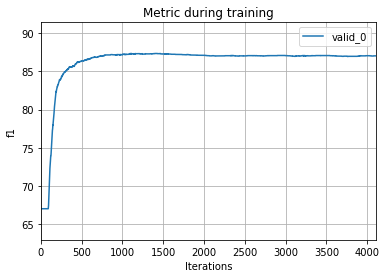

In [72]:
parameters = {
    'metric': 'f1',
    'learning_rate': 0.005,
    'verbose': 0,
    'feature_fraction': 0.6,
    'num_leaves': 43,
    'lambda_l1': 2.7377447077547212, 'lambda_l2': 6.91387710746705e-05
}
#parameters = {**parameters, **best_params}
print(parameters)
evals_result = {}
model = lgb.train(parameters,
                       x_train,
                       valid_sets=x_valid,
                       num_boost_round=30000,
                       early_stopping_rounds=3000,
                       feval=lgb_f1_score,
                       evals_result=evals_result,
                       verbose_eval=2000)
lgb.plot_metric(evals_result, metric='f1')


In [73]:
y_pred = np.round(model.predict(x_test))
print(y_pred[:5])

[0. 0. 0. 0. 0.]


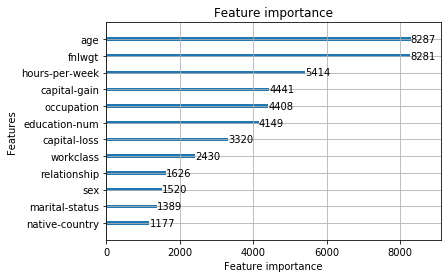

In [74]:
lgb.plot_importance(model)